In [1]:
import numpy as np
import pandas as pd

import requests
import sys
import os

# looking for extreme values that lie in the top 0.3% or bottom 0.3% of your data
# identify potentially significant market movements or anomalies

In [3]:
def get_futures_current_price(symbol):
    url = f"https://fapi.binance.com/fapi/v1/ticker/price?symbol={symbol}"
    response = requests.get(url)
    data = response.json()
    return float(data['price'])

def send_telegram_message(message):
    bot_token = ''
    chat_id = ''
    channel_username = '@Crypto_anomalies_alert'
    url = f'https://api.telegram.org/bot{bot_token}/sendMessage'
    params = {'chat_id': channel_username, 'text': message}
    response = requests.post(url, json=params)

def fetch_kline_data(symbol): # 4hour
    endpoint = f"https://fapi.binance.com/fapi/v1/klines?symbol={symbol}&limit=240&interval=1m"
    response = requests.get(endpoint)
    return response.json() if response.status_code == 200 else None

def calculate_returns(close_prices):
    returns = np.diff(close_prices) / close_prices[:-1]
    absolute_returns = np.abs(returns)
    return absolute_returns

def check_trigger(returns, std):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    last_return = returns[-1]
    if last_return > mean_return + (std * std_return) or last_return < mean_return - (std * std_return):
        return True
    else:
        return False

# BY PRICE_CHANGE
# def fetch_top_crypto_close_prices():
#     binance_endpoint_24hr = "https://fapi.binance.com/fapi/v1/ticker/24hr"
#     response = requests.get(binance_endpoint_24hr)
#     binance_response_24hr = response.json()
#     filtered_response = [item for item in binance_response_24hr if item['symbol']]
#     sorted_data = sorted(filtered_response, key=lambda x: float(x['priceChangePercent']), reverse=True)
#     symbols_sorted_by_percent_change = [item['symbol'] for item in sorted_data]
#     return symbols_sorted_by_percent_change

# BY VOLUME
def fetch_top_crypto_close_prices():
    binance_endpoint_24hr = "https://fapi.binance.com/fapi/v1/ticker/24hr"
    response = requests.get(binance_endpoint_24hr)
    binance_response_24hr = response.json()
    filtered_response = [item for item in binance_response_24hr if item['symbol']]
    sorted_data = sorted(filtered_response, key=lambda x: float(x['quoteVolume']), reverse=True)
    symbols_sorted_by_percent_change = [item['symbol'] for item in sorted_data]
    return symbols_sorted_by_percent_change

def run_job():
    for symbol in fetch_top_crypto_close_prices()[:100]:
        kline_data = fetch_kline_data(symbol)
        close_prices = [float(candle[4]) for candle in kline_data]  # Extract close prices from the Kline data
        returns = calculate_returns(close_prices)
        trigger = check_trigger(returns, std = 3)
        if trigger:
            message = f"https://www.binance.com/en/futures/{symbol}"
            send_telegram_message(message)

def main():
    while True:
        run_job()

# EXECUTION

# if __name__ == "__main__":
#     try:
#         main()
#     except Exception as e:
#         # Log the error
#         print(f"Fatal error: {e}. Restarting script.")
        
#         # Restart the script
#         os.execl(sys.executable, sys.executable, *sys.argv)

In [ ]:
#마지막이 하락인지 상승인지 확인 필요
# 트리거 되자마자 0.3% 먹기
#  이거 백테스팅 필요 (오늘할일)


# BACKTEST 

In [3]:
import datetime as dt
import time
from binance.client import Client
from binance.enums import *
from binance.cm_futures import CMFutures

#API
api_key = ''
api_secret = ''

client = Client(api_key,api_secret)


#### Setting plotting and display options
import matplotlib.pyplot as plt
import matplotlib as mpl

np.set_printoptions(precision = 3)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [4]:
coin = "1000PEPEUSDT"

date_now = dt.datetime.now()
date_start = date_now-dt.timedelta(days=1)
now = date_now.strftime("%Y-%m-%d %H:%M:%S")
start = date_start.strftime("%Y-%m-%d")

df = pd.DataFrame(client.futures_historical_klines(
    symbol=coin,
    interval=client.KLINE_INTERVAL_1MINUTE, # can play with this e.g. '1h', '4h', '1w', etc.
    start_str=start,
    end_str=now
))
df = df.iloc[:, :6]
df.columns = ['date', 'open', 'high', 'low', f'{coin}', 'volume']
df['date'] = pd.to_datetime(df['date'], unit='ms')
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])
df = df.set_index("date")
data = df[[coin]]

data["Return"] = data[coin].pct_change()
pd.set_option('display.max_rows', 10)

data


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/2071156349.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


,1000PEPEUSDT,Return
date,,
2024-02-22 00:00:00,0.001,NaN
2024-02-22 00:01:00,0.001,0.001
2024-02-22 00:02:00,0.001,-0.003
2024-02-22 00:03:00,0.001,0.000
2024-02-22 00:04:00,0.001,-0.002
...,...,...
2024-02-23 11:00:00,0.001,-0.003
2024-02-23 11:01:00,0.001,0.005
2024-02-23 11:02:00,0.001,0.011


In [14]:
df = data.copy()
sigma = 5
window_size = 400  # Assuming you're using a rolling window of 400 observations

df.sort_index(inplace=True)

df['POS'] = 0

rolling_mean = df['Return'].abs().rolling(window=window_size).mean()
rolling_std = df['Return'].abs().rolling(window=window_size).std()

for n in range(window_size, len(df)):
    current_return = df.iloc[n]['Return']
    mean_return = rolling_mean.iloc[n]
    std_return = rolling_std.iloc[n]

    if abs(current_return) > mean_return + (sigma * std_return):
        df.at[df.index[n], 'POS'] = 1 if current_return > 0 else -1
pd.set_option('display.max_rows', 10)

df

,1000PEPEUSDT,Return,POS
date,,,
2024-02-22 00:00:00,0.001,NaN,0
2024-02-22 00:01:00,0.001,0.001,0
2024-02-22 00:02:00,0.001,-0.003,0
2024-02-22 00:03:00,0.001,0.000,0
2024-02-22 00:04:00,0.001,-0.002,0
...,...,...,...
2024-02-23 11:00:00,0.001,-0.003,0
2024-02-23 11:01:00,0.001,0.005,0
2024-02-23 11:02:00,0.001,0.011,0


In [62]:
df['stratReturn'].iloc[-1]

0.06536359097253197

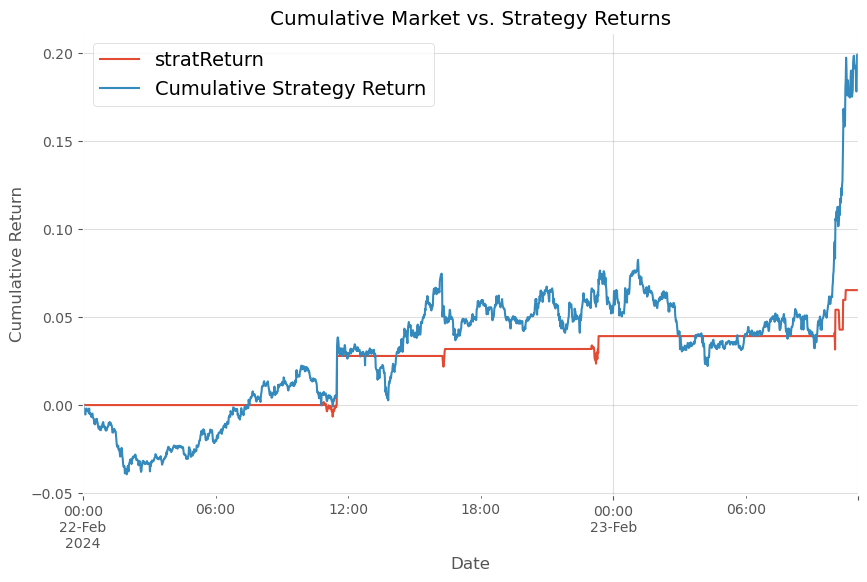

In [32]:
import pandas as pd
import numpy as np

df['Action'] = 0

# Initialize variables to track the state
in_position = False
long_position = False
short_position = False
cumulative_return = 0.0

for i in range(len(df) - 1):  # Adjust loop to stop before the last row
    if not in_position:
        if df.iloc[i]['POS'] != 0:
            in_position = True
            cumulative_return = 0.0  # Reset cumulative return
            if df.iloc[i]['POS'] == 1:
                long_position = True
            elif df.iloc[i]['POS'] == -1:
                short_position = True
            continue  # Skip the rest of the loop to avoid adding return on the entry row
    else:
        # Safely update cumulative return with the next row's return
        if long_position:
            cumulative_return += df.iloc[i]['Return']
        if short_position:
            cumulative_return += df.iloc[i]['Return'] * -1

        df.at[df.index[i], 'Action'] = 1 if long_position else -1
        
        # Check for take profit or stop loss conditions
        if cumulative_return > 0.003 or cumulative_return < -0.01:  # TP/SL
            in_position = long_position = short_position = False # Exit position

pd.set_option('display.max_rows', 10)

df['stratReturn'] = (df['Return'] * df['Action']).cumsum()
df['stratReturn'].plot(figsize=(10, 6), title='Strategy Return Over Time')
df['Return'].cumsum().plot(label='Cumulative Strategy Return')

plt.legend()
plt.title('Cumulative Market vs. Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

plt.show()



# BACKTEST FINAL

In [111]:
def backtestSpike(coin, days, sigma, window_size, TP, SL, plot = False):

    #coin = "1000PEPEUSDT"

    date_now = dt.datetime.now()
    date_start = date_now-dt.timedelta(days) #(days = 1)
    now = date_now.strftime("%Y-%m-%d %H:%M:%S")
    start = date_start.strftime("%Y-%m-%d")

    df = pd.DataFrame(client.futures_historical_klines(
        symbol=coin,
        interval=client.KLINE_INTERVAL_1MINUTE, # can play with this e.g. '1h', '4h', '1w', etc.
        start_str=start,
        end_str=now
    ))
    df = df.iloc[:, :6]
    df.columns = ['date', 'open', 'high', 'low', f'{coin}', 'volume']
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])
    df = df.set_index("date")
    data = df[[coin]]

    data["Return"] = data[coin].pct_change()
    pd.set_option('display.max_rows', 10)

    df = data.copy()
    # sigma = 5
    # window_size = 400  # Assuming you're using a rolling window of 400 observations

    df.sort_index(inplace=True)

    df['POS'] = 0

    rolling_mean = df['Return'].abs().rolling(window=window_size).mean()
    rolling_std = df['Return'].abs().rolling(window=window_size).std()

    for n in range(window_size, len(df)):
        current_return = df.iloc[n]['Return']
        mean_return = rolling_mean.iloc[n]
        std_return = rolling_std.iloc[n]

        if abs(current_return) > mean_return + (sigma * std_return):
            df.at[df.index[n], 'POS'] = 1 if current_return > 0 else -1

    df['Action'] = 0

    # Initialize variables to track the state
    in_position = False
    long_position = False
    short_position = False
    cumulative_return = 0.0

    for i in range(len(df) - 1):  
        if not in_position:
            if df.iloc[i]['POS'] != 0:
                in_position = True
                cumulative_return = 0.0  
                if df.iloc[i]['POS'] == 1:
                    long_position = True
                elif df.iloc[i]['POS'] == -1:
                    short_position = True
                continue  
        else:
            if long_position:
                cumulative_return += df.iloc[i]['Return']
            if short_position:
                cumulative_return += df.iloc[i]['Return'] * -1

            df.at[df.index[i], 'Action'] = 1 if long_position else -1
            
            if cumulative_return > TP or cumulative_return < SL:  # TP/SL
                in_position = long_position = short_position = False # Exit position

    df['stratReturn'] = (df['Return'] * df['Action']).cumsum()
    finalReturn = df['stratReturn'].iloc[-1]
    trade_count = (df['POS'] != 0).sum()

    if plot:         
        pd.set_option('display.max_rows', 10)
        df['stratReturn'].plot(figsize=(10, 6), title='Strategy Return Over Time')
        df['Return'].cumsum().plot(label='Market Return')

        # Adding legend to distinguish the lines
        plt.legend()

        # Adding title and labels
        plt.title('Cumulative Market vs. Strategy Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')

        # Show plot
        return plt.show()
    
    return finalReturn, trade_count*0.001

In [115]:
backtestSpike(coin= 'INJUSDT', days= 30, sigma= 4, window_size= 240, TP= 0.005, SL= -0.01, plot= False)

/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/4226046630.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


(0.006218195171765362, 0.264)

In [79]:
TP_list = [0.002, 0.003, 0.005, 0.01, 0.02]
SL_list = [-0.002, -0.003, -0.005, -0.01, -0.02]
sigma_list = np.arange(2,6, 1)
window_size_list = np.arange(240, 1500, 240)
coin_list = ['INJUSDT', 'ONDOUSDT']

In [77]:
backtestSpike(coin= 'INJUSDT', days= 5, sigma= 5, window_size= 240, TP= 0.003, SL= -0.01, plot= False)

/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


-0.04529252419458385

In [83]:
results = []

for coin in coin_list:
    for TP in TP_list:
        for SL in SL_list:
            for sigma in sigma_list:
                for window_size in window_size_list:
                    output = backtestSpike(coin=coin, days=5, sigma=sigma, window_size=window_size, TP=TP, SL=SL, plot=False)
                    
                    results.append({
                        'Coin': coin,
                        'TP': TP,
                        'SL': SL,
                        'Sigma': sigma,
                        'Window Size': window_size,
                        'Output': output
                    })
                    print(f'Coin: {coin}, TP: {TP}, SL: {SL}, Sigma: {sigma}, Window Size: {window_size}, Output: {output}')

df_results = pd.DataFrame(results)

df_sorted = df_results.sort_values(by='Output', ascending=False)

df_sorted.to_csv('backtest_results.csv', index=False)

print(df_sorted)


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 240, Output: -0.029726359230012767


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 480, Output: 0.0008193865566380465


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 720, Output: -0.04882745107660358


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 960, Output: -0.05104949364525291


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 1200, Output: -0.032459997696699605


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 1440, Output: -0.038780893114881754


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 240, Output: -0.015125684605629464


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 480, Output: 0.03512836656566787


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 720, Output: 0.038474668739334916


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 960, Output: 0.04436935315249402


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 1200, Output: 0.025959015816528708


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 1440, Output: 0.02537117699228686


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 240, Output: 0.02869274885634121


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 480, Output: 0.010658273990720057


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 720, Output: -0.011028165304306392


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 960, Output: -0.016571746324557046


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 1200, Output: 0.029741407229840644


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 4, Window Size: 1440, Output: 0.03676065825601749


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 240, Output: 0.0035545144302078224


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 480, Output: 0.013238941032053808


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 720, Output: 0.010205901932326622


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 960, Output: 0.004693036087881963


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 1200, Output: -0.006672270760265664


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.002, Sigma: 5, Window Size: 1440, Output: -0.01621765303116296


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 240, Output: -0.07528812749505465


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 480, Output: -0.08820040960724063


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 720, Output: -0.12380101860510906


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 960, Output: -0.11935575514601304


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 1200, Output: -0.09251970421270017


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 2, Window Size: 1440, Output: -0.10245448754976916


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 240, Output: -0.023681412240197708


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 480, Output: -0.02658024787547353


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 720, Output: -0.026199022775231895


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 960, Output: -0.019606584863209986


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 1200, Output: -0.032752395684304325


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 3, Window Size: 1440, Output: -0.026407791004414594


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 240, Output: 0.04217785271615637


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 480, Output: 0.026889167351545007


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 720, Output: 0.002105626165854746


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 960, Output: -0.007828023061457134


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 1200, Output: 0.002206778638102036


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 4, Window Size: 1440, Output: 0.006682109326740959


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 240, Output: -0.0003033629007394012


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 480, Output: 0.01933246700536373


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 720, Output: 0.015370159906423542


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 960, Output: 0.00846997809368899


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 1200, Output: -0.002895328754458637


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.003, Sigma: 5, Window Size: 1440, Output: -0.007313463668935594


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 240, Output: 0.015395474862037517


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 480, Output: -0.012077756509107584


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 720, Output: -0.03356270843468012


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 960, Output: -0.05891734860149622


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 1200, Output: -0.028149751050958183


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 2, Window Size: 1440, Output: -0.0620767794707765


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 240, Output: -0.012636364258725385


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 480, Output: -0.04359905972841038


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 720, Output: -0.03943508630961956


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 960, Output: -0.009453698435134661


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 1200, Output: -0.03078738042906848


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 3, Window Size: 1440, Output: -0.03767526328167503


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 240, Output: 0.05856872525739798


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 480, Output: 0.02441954899033605


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 720, Output: 0.0007879341105253568


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 960, Output: -0.005554876857446378


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 1200, Output: 0.004479924842112792


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 4, Window Size: 1440, Output: 0.014981535402341262


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 240, Output: -0.005470220885410049


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 480, Output: 0.012241243314744188


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 720, Output: -0.0002758122739940916


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 960, Output: -0.009010243009239804


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 1200, Output: -0.02037554985738743


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.005, Sigma: 5, Window Size: 1440, Output: -0.014218399809426518


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 240, Output: 0.09814001647349868


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 480, Output: 0.039624679712198185


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 720, Output: 0.05000800881076928


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 960, Output: 0.061452772277865386


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 1200, Output: 0.09375488496488216


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 2, Window Size: 1440, Output: 0.1143309638728518


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 240, Output: 0.10624788448647748


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 480, Output: 0.0410510218776291


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 720, Output: 0.06184714216582832


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 960, Output: 0.08567722753371143


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 1200, Output: 0.0801591647588652


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 3, Window Size: 1440, Output: 0.053842912290263945


/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/91862772.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


Coin: INJUSDT, TP: 0.002, SL: -0.01, Sigma: 4, Window Size: 240, Output: 0.07309442669453059


KeyboardInterrupt: 

# 여기부터 제대로

In [87]:
coin_list = ['INJUSDT', 'ONDOUSDT']
coin = 'ONDOUSDT'
days = 5

date_now = dt.datetime.now()
date_start = date_now-dt.timedelta(days) #(days = 1)
now = date_now.strftime("%Y-%m-%d %H:%M:%S")
start = date_start.strftime("%Y-%m-%d")

df = pd.DataFrame(client.futures_historical_klines(
    symbol=coin,
    interval=client.KLINE_INTERVAL_1MINUTE, # can play with this e.g. '1h', '4h', '1w', etc.
    start_str=start,
    end_str=now
))
df = df.iloc[:, :6]
df.columns = ['date', 'open', 'high', 'low', f'{coin}', 'volume']
df['date'] = pd.to_datetime(df['date'], unit='ms')
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])
df = df.set_index("date")
data = df[[coin]]

data["Return"] = data[coin].pct_change()
pd.set_option('display.max_rows', 10)

df = data.copy()

/var/folders/xj/8fm23lb137v05ps150d3h5kr0000gn/T/ipykernel_3864/3295486202.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data[coin].pct_change()


In [88]:
def backtestDEMO(df, sigma, window_size, TP, SL, plot = False):
    df.sort_index(inplace=True)

    df['POS'] = 0

    rolling_mean = df['Return'].abs().rolling(window=window_size).mean()
    rolling_std = df['Return'].abs().rolling(window=window_size).std()

    for n in range(window_size, len(df)):
        current_return = df.iloc[n]['Return']
        mean_return = rolling_mean.iloc[n]
        std_return = rolling_std.iloc[n]

        if abs(current_return) > mean_return + (sigma * std_return):
            df.at[df.index[n], 'POS'] = 1 if current_return > 0 else -1

    df['Action'] = 0

    in_position = False
    long_position = False
    short_position = False
    cumulative_return = 0.0

    for i in range(len(df) - 1):  
        if not in_position:
            if df.iloc[i]['POS'] != 0:
                in_position = True
                cumulative_return = 0.0  
                if df.iloc[i]['POS'] == 1:
                    long_position = True
                elif df.iloc[i]['POS'] == -1:
                    short_position = True
                continue  
        else:
            if long_position:
                cumulative_return += df.iloc[i]['Return']
            if short_position:
                cumulative_return += df.iloc[i]['Return'] * -1

            df.at[df.index[i], 'Action'] = 1 if long_position else -1
            
            if cumulative_return > TP or cumulative_return < SL:  # TP/SL
                in_position = long_position = short_position = False # Exit position

    df['stratReturn'] = (df['Return'] * df['Action']).cumsum()
    finalReturn = df['stratReturn'].iloc[-1]
    
    
    if plot:         
        pd.set_option('display.max_rows', 10)
        df['stratReturn'].plot(figsize=(10, 6), title='Strategy Return Over Time')
        df['Return'].cumsum().plot(label='Market Return')

        plt.legend()

        plt.title('Cumulative Market vs. Strategy Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')

        return plt.show()
    
    return finalReturn

In [89]:
results = []

for TP in TP_list:
    for SL in SL_list:
        for sigma in sigma_list:
            for window_size in window_size_list:
                output = backtestDEMO(df=df, sigma=sigma, window_size=window_size, TP=TP, SL=SL, plot=False)
                
                results.append({
                    'Coin': coin,
                    'TP': TP,
                    'SL': SL,
                    'Sigma': sigma,
                    'Window Size': window_size,
                    'Output': output
                })
                print(f'Coin: {coin}, TP: {TP}, SL: {SL}, Sigma: {sigma}, Window Size: {window_size}, Output: {output}')

df_results = pd.DataFrame(results)

df_sorted = df_results.sort_values(by='Output', ascending=False)

df_sorted.to_csv(f'{coin}_backtest_results.csv', index=False)

print(df_sorted)


Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 240, Output: 0.030282567578156616
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 480, Output: 0.0021587881194461422
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 720, Output: 0.14991811015780843
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 960, Output: 0.1409430889280474
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 1200, Output: 0.05944649852986439
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 2, Window Size: 1440, Output: 0.04525959207795227
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 240, Output: -0.03431986144929533
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 480, Output: 0.0945449047113921
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 720, Output: 0.09075498699465501
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 3, Window Size: 960, Output: 0.09321106348827723
Coin: ONDOUSDT, TP: 0.002, SL: -0.002, Sigma: 

In [103]:
pd.set_option('display.max_rows', 10)

df1 = pd.read_csv('INJUSDT_backtest_results.csv')
df2 = pd.read_csv('ONDOUSDT_backtest_results.csv')

df2

,Coin,TP,SL,Sigma,Window Size,Output
0,ONDOUSDT,0.010,-0.020,2,720,0.489
1,ONDOUSDT,0.010,-0.020,3,1440,0.471
2,ONDOUSDT,0.020,-0.010,2,720,0.429
3,ONDOUSDT,0.010,-0.020,3,480,0.425
4,ONDOUSDT,0.005,-0.020,3,480,0.342
...,...,...,...,...,...,...
595,ONDOUSDT,0.020,-0.003,5,480,-0.079
596,ONDOUSDT,0.020,-0.002,5,960,-0.081
597,ONDOUSDT,0.003,-0.020,2,1200,-0.086
598,ONDOUSDT,0.020,-0.002,5,1200,-0.089


In [ ]:
import 

Best parameters:
TP              0.005
SL             -0.010
Sigma           2.000
Window Size   240.000
Output          0.213
Name: 264, dtype: float64


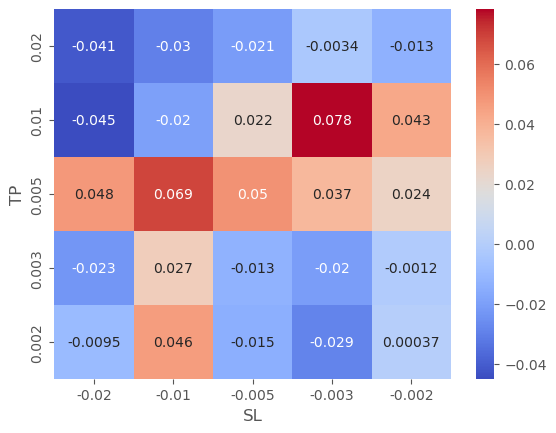

'\nEach cell in the heatmap represents a combination of TP and SL parameters.\nThe color intensity of each cell corresponds to the average output value for that combination. Warmer colors (e.g., red) typically indicate higher average output values, while cooler colors (e.g., blue) indicate lower average output values.\nThe annot parameter set to True in sns.heatmap adds numerical annotations to each cell, displaying the average output value.\n'

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.concat([df1, df2], ignore_index=True)

# Group by parameters and calculate aggregate statistics
grouped_df = df1.groupby(['TP', 'SL', 'Sigma', 'Window Size']).agg({'Output': 'mean'}).reset_index()

# Visualize the performance using a heatmap
heatmap_data = grouped_df.pivot_table(index='TP', columns='SL', values='Output')
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
heatmap_data = heatmap_data.sort_index(ascending=False)
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')

# Identify the best parameters
best_params = grouped_df.loc[grouped_df['Output'].idxmax()]

print("Best parameters:")
print(best_params)

plt.show()  # Show the plot


'''
Each cell in the heatmap represents a combination of TP and SL parameters.
The color intensity of each cell corresponds to the average output value for that combination. Warmer colors (e.g., red) typically indicate higher average output values, while cooler colors (e.g., blue) indicate lower average output values.
The annot parameter set to True in sns.heatmap adds numerical annotations to each cell, displaying the average output value.
'''
